In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
# %matplotlib auto

In [3]:
from pathlib import Path
import cv2
import pickle as pkl
import PIL
import numpy as np
import pandas as pd
from copy import deepcopy
import time
import sys
from scipy.spatial.transform import Rotation as R

In [4]:
import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.pyplot import GridSpec

In [5]:
sys.path.append("/scratch/abhijatb/Bosch22")
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus
from parser_utils import GetGazeDeviationFromHead
from ibmmpy.src.ibmmpy.ibmm import EyeClassifier

In [6]:
from dreyevr_attnmap_utils import *
from dreyevr_viz.lbc_data_utils import get_data

In [7]:
dataset_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/")
route_data_path = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_brady32")
aux_hitpts_root = Path('/scratch/abhijatb/Bosch22/carla.harp_p13bd/Dist/CARLA_Shipping_0.9.12-211-ga7c19cced-dirty/LinuxNoEditor/CarlaUE4/FocusInfoOuts')
aux_hitpt_filename = str(route_data_path.stem.strip("exp_"))
aux_hitpt_file = aux_hitpts_root / Path(aux_hitpt_filename + ".txt")

In [8]:
dreyevr_recording_txt_root = Path("/scratch/abhijatb/Bosch22/dreyevr_recordings/RecordingTxts/pre-newCA/")
movie_save_dir = "/scratch/bpardhi/visualize_dreyevr_agent_saliency/gaze_outputs/"

In [9]:
# read a recording
route_data_path = Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11')
# load the dreyevr data from recording txt
participant_name_route = route_data_path.stem.split('_')[-1]
participant_name = participant_name_route[:-2]
recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

dreyevr_data_path =  route_data_path / "dreyevr_data"

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.273s


In [10]:
# read focus hitpts from the aux replay outputs and parse them 
# (older recordings have focus hitpt computed on channel that blocks invisble actors which is undesirable)

apply_focusinfohitpt_correction=True

## Movie generation

In [11]:
route_data_paths = list(Path("/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/").glob("*/"))
route_data_paths.insert(0, Path('/scratch/abhijatb/Bosch22/dreyevr_recordings_sensors/LBC_config_gaze/exp_tab11'))

for route_data_path in route_data_paths:
    # load the dreyevr data from recording txt
    try:
        participant_name_route = route_data_path.stem.split('_')[-1]
        participant_name = participant_name_route[:-2]
        recordingtxt_path = dreyevr_recording_txt_root / participant_name / (participant_name_route + ".txt")
        df_new = load_dreyevr_data_and_gazeevent_annotate(recordingtxt_path)

        aux_hitpt_filename = str(route_data_path.stem.strip("exp_"))
        aux_hitpt_file = aux_hitpts_root / Path(aux_hitpt_filename + ".txt")
        if apply_focusinfohitpt_correction:
            FocusInfoHitPts_fixed = loadFocusInfoCorrected(aux_hitpt_file, len(df_new))
            df_new = df_new.assign(FocusInfo_HitPoint=FocusInfoHitPts_fixed)

        dreyevr_data_path =  route_data_path / "dreyevr_data"


        overlay_rad=1
        # write a movie with gaze overlay
        movie_title = participant_name_route + ".mkv"
        if Path(movie_save_dir+movie_title).exists():
            continue

        resolution=200
        FFMpegWriter = manimation.writers['ffmpeg']
        metadata = dict(title=movie_title, artist='ajdroid', comment='dreyevrLBC-gaze-to-cam')
        writer = FFMpegWriter(fps=2, metadata=metadata)

        final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
        datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
        prog = '' ; total_frames = datapt_idcs[-1]
        start = time.time()

        fig = plt.figure(dpi=resolution)
        gaze_memory_window=50 # this is number of ticks, x/20 is num seconds
        gaze_frames_per_img = 10

        with writer.saving(fig, movie_save_dir+movie_title, resolution):
            for tick in range(1*10 + gaze_memory_window, (total_frames-3)*10, 10):
                vehicle_transform = None
                tickbyten = tick//10
                tick_data = get_data(route_data_path, tickbyten)

                rgb_img = deepcopy(tick_data['rgb'])
                left_img = deepcopy(tick_data['rgb_left'])
                right_img = deepcopy(tick_data['rgb_right'])

                gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
                gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
                gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))

                for tick_mem in np.arange(tick, tick-gaze_memory_window, -1):
                    dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
                    with open(dreyevr_data_t1, 'rb') as f:
                        dreyevr_data_dict = pkl.load(f)

                    tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]

                    if tick_mem==tick:
                        # if you want attention map using 3d locations rather than pixel locs, use current vehicle loc 
                        # instead of vehicle loc at the time
                        vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
                        vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
                        vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)

                    # need to remove the saccades
                    tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())/100 # cm -> m

                    gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
                    gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
                    gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
                    gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft

            #         print(tick_row_df["label"].squeeze())

                    if tick_row_df["label"].squeeze() == 0:
                        dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], r=overlay_rad)
                        dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], r=overlay_rad)
                        dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], r=overlay_rad)
                    elif tick_row_df["label"].squeeze() == 1:
                        color = (255, 0, 0)
                        dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], color=color, r=overlay_rad)
                        dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], color=color, r=overlay_rad)
                        dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], color=color, r=overlay_rad)

                img_3stack = np.hstack([left_img, rgb_img, right_img])

                plt.imshow(img_3stack)

                writer.grab_frame() ; fig.clear()
                tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
                print('\ttime: {} | progress: {:.1f}%'.format(tstr, 100*tickbyten/total_frames), end='\r')
    except:
        print("Couldn't process ", route_data_path)
    break

Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/tab11.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.304s
Loaded data from /scratch/abhijatb/Bosch22/dreyevr_parser/cache/brady32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.187s


## Debug image generation

In [12]:
overlay_rad = 1
gaze_memory_window=50 # this is number of ticks, x/20 is num seconds
# 269
# 80
# get total num of frames
final_datapt_idx = int(sorted(list((route_data_path/'rgb').glob('*.png')))[-1].stem)
datapt_idcs = np.arange(final_datapt_idx)+1 # starts from 0001.png
total_frames = datapt_idcs[-1]

# with writer.saving(fig, movie_save_dir+movie_title, resolution):

for tick in range(10*10, (total_frames-3)*10):
    tickbyten = tick//10
    tick_data = get_data(route_data_path, tickbyten)
    rgb_img = deepcopy(tick_data['rgb'])
    left_img = deepcopy(tick_data['rgb_left'])
    right_img = deepcopy(tick_data['rgb_right'])
    
    gaze_in_cam_arr = np.zeros((gaze_memory_window, 2))
    gaze_in_cam_arr_rgt = np.zeros((gaze_memory_window, 2))
    gaze_in_cam_arr_lft = np.zeros((gaze_memory_window, 2))
    
    for tick_mem in np.arange(tick, tick-gaze_memory_window, -1):
        dreyevr_data_t1 = dreyevr_data_path / ("{:04d}_{:05d}.pkl".format(tick_mem//10, tick_mem))
        with open(dreyevr_data_t1, 'rb') as f:
            dreyevr_data_dict = pkl.load(f)
            
        tick_row_df = df_new[df_new.FrameSequence == dreyevr_data_dict['framesequence']]

#         if tick_mem==tick:
#             # if you want attention map in current location, use current vehicle loc 
#             # instead of vehicle loc at the time
        vehicle_loc = carla.Location(*(tick_row_df['VehicleLoc'].squeeze()))/100
        vehicle_rot = carla.Rotation(*(tick_row_df['VehicleRot'].squeeze()))    
        vehicle_transform = carla.Transform(location=vehicle_loc, rotation=vehicle_rot)
                
                #TODO: need to remove the saccades
        if apply_focusinfohitpt_correction:
            tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())            
        else:
            tick_focus_hitpt = np.array(tick_row_df.FocusInfo_HitPoint.squeeze())
        
        tick_focus_hitpt /= 100 # cm -> m
        
        gaze_in_cam_mid, gaze_in_cam_lft, gaze_in_cam_rgt  = world2pixels(tick_focus_hitpt, vehicle_transform, K)
        gaze_in_cam_arr[tick - tick_mem] = gaze_in_cam_mid
        gaze_in_cam_arr_rgt[tick - tick_mem] = gaze_in_cam_rgt
        gaze_in_cam_arr_lft[tick - tick_mem] = gaze_in_cam_lft
        
#         print(tick_row_df["label"].squeeze())

        # if tick_row_df["label"].squeeze() == 0:
        #     dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], r=overlay_rad)
        #     dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], r=overlay_rad)
        #     dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], r=overlay_rad)
        #     print("left", gaze_in_cam_lft)

        # elif tick_row_df["label"].squeeze() == 1:
        #     color = (255, 0, 0)
        #     dot(rgb_img, gaze_in_cam_mid[0], gaze_in_cam_mid[1], color=color, r=overlay_rad)
        #     dot(right_img, gaze_in_cam_rgt[0], gaze_in_cam_rgt[1], color=color, r=overlay_rad)
        #     dot(left_img, gaze_in_cam_lft[0], gaze_in_cam_lft[1], color=color, r=overlay_rad)
        #     print("left", gaze_in_cam_lft)
        # img_3stack = np.hstack([left_img, rgb_img, right_img])
        
#         if tick>31:
        plt.imshow(img_3stack)
    break

In [15]:
# A function to get a gaussian blob of image size centered at x,y
from PIL import Image
import scipy.stats as stats

def get_gaussian_blob(x, y, sigma, img_size, radius):
    attentionMap = np.zeros(img_size) # 2D array of zeros
    # check if x and y are within the image size
    if x < 0 or y < 0 or x >= img_size[0] or y >= img_size[1]:
        return attentionMap

    # create a mask of size radius centered at x,y
    A, B = np.ogrid[:img_size[0], :img_size[1]]
    dist_from_center = np.sqrt((A - x) ** 2 + (B - y) ** 2)
    mask = dist_from_center <= radius
    
    # create gaussian kernel
    size = 2 * radius
    X = np.linspace(-sigma, sigma, size + 1)
    Y = np.diff(stats.norm.cdf(X))
    kernel = np.outer(Y, Y)
    kernel = kernel / kernel.sum()

    # apply the kernel to the attention map
    xMin = max(0, x - radius)
    xMax = min(img_size[0], x + radius)
    yMin = max(0, y - radius)
    yMax = min(img_size[1], y + radius)

    xMinKernel = max(0, radius - x)
    xMaxKernel = min(size, radius + img_size[0] - x)
    yMinKernel = max(0, radius - y)
    yMaxKernel = min(size, radius + img_size[1] - y)

    attentionMap[xMin:xMax, yMin:yMax] = kernel[xMinKernel:xMaxKernel, yMinKernel:yMaxKernel]
    
    # set all the values outside the mask to 0
    attentionMap[~mask] = 0    
    
    return attentionMap

# A function that takes in an array of gaze points and returns an attention map
def get_attention_map(gazeCoords, imgShape, sigma=1, radius = 1):
    '''
    Here the gazeCoords corresponds to all the gaze points 
    '''
    # create a zero array of the size of the image
    attentionMap = np.zeros(imgShape)
    # for each gaze point, add a gaussian blob to the attention map
    for gazePoint in gazeCoords:
        # get the x and y coordinates of the gaze point
        x, y = gazePoint
        # add a gaussian blob to the attention map
        attentionMap += get_gaussian_blob(x, y, sigma, imgShape, radius=radius)
    # return the attention map
    return attentionMap
    
# a function to draw the attention map on the image
def draw_attention_map(gazeCoords, 
                                        img, 
                                        alpha=0.3, 
                                        sigma= 5, 
                                        radius = 10, 
                                        image_blur = False, 
                                        glob_blur = True, 
                                        color_= True):
    # input is a PIL image
    # convert the image to numpy array
    img = np.array(img)
    # interchange the x and y coordinates
    gazeCoordsNew = (np.array(gazeCoords)[:, [1, 0]]).astype(int)
    # get the attention map
    attentionMap = get_attention_map(gazeCoordsNew, img.shape[:2], sigma=sigma, radius=radius)

    if image_blur:
        # blur the image except the region of interest
        img[attentionMap == 0] = cv2.blur(img, (7, 7))[attentionMap == 0]
    
    if glob_blur:
        # apply attention map with alpha blending to the image
        if color_:
            # color the attention map to Jet colormap
            attentionMapCopy = attentionMap.copy()
            attentionMapCopy = attentionMapCopy / attentionMapCopy.max()
            heatMap = cv2.applyColorMap(np.uint8(255 * attentionMapCopy), cv2.COLORMAP_JET)

            # invert colors of heat map
            heatMap = cv2.bitwise_not(heatMap)
            
            # apply the heatMap to the image only where the attention map is greater than 0
            img[attentionMap > 0] = img[attentionMap > 0] * (1 - alpha) + heatMap[attentionMap > 0] * (alpha)
        else:
            img[attentionMap > 0] = img[attentionMap > 0] * (1 - alpha) + attentionMap[attentionMap > 0][:, None] * 255 * (alpha)

    # convert the image back to PIL image
    img = Image.fromarray(img.astype('uint8'))
    return img


In [14]:
print(np.array(rgb_img).shape)
print(np.array(left_img).shape)
print(np.array(right_img).shape)
print(rgb_img.size)

(144, 256, 3)
(144, 256, 3)
(144, 256, 3)
(256, 144)


In [18]:
image = draw_attention_map(gaze_in_cam_arr, rgb_img, alpha=0.3, sigma= 1, radius = 5, image_blur = False, glob_blur = True)
imageLeft = draw_attention_map(gaze_in_cam_arr_lft, left_img, alpha=0.3, sigma= 1, radius = 5, image_blur = False, glob_blur = True)
imageRight = draw_attention_map(gaze_in_cam_arr_rgt, right_img, alpha=0.5, sigma= 1, radius = 5, image_blur = False, glob_blur = True, color_=False)
# plot the image
plt.imshow(imageRight)
plt.savefig('test.png')

In [ ]:
np.array(tick_row_df.FocusInfo_HitPoint_fixed.squeeze())

In [31]:
debug_fig = plt.figure(figsize=(15, 45))
plt.imshow(np.array(rgb_img))
plt.savefig('debug_rgb.png')
plt.imshow(np.array(left_img))
plt.savefig('debug_left.png')
plt.imshow(np.array(right_img))
plt.savefig('debug_right.png')

In [ ]:
debug_fig

In [ ]:
debug_fig = plt.figure(figsize=(15, 45))
plt.imshow(img_3stack)

In [ ]:
# then do the 3 sensor gaze overlay with corrected focus hitpts
# (do gaze event classification)
# then convert to attention maps (history + dispersion)

In [28]:
%matplotlib inline

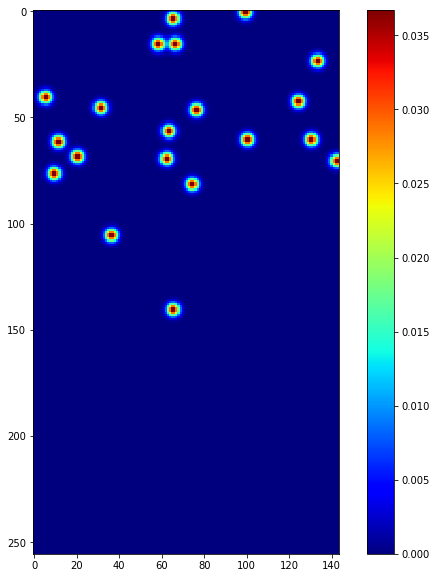

In [33]:
# test the function
# create a random array of gaze points
gazeCoords = np.random.randint(0, 144, (20, 2))
# get the attention map
attentionMap = get_attention_map(gazeCoords, (256, 144), 5, 10)
# plot the attention map of big size
plt.figure(figsize=(10, 10))

# create a numpy array of the attention map
attentionMap = np.array(attentionMap)
# show the attention map# add a colorbar with Jet colormap
plt.imshow(attentionMap, cmap='jet')
plt.colorbar()
plt.show()
